In [167]:
from __future__ import absolute_import, division

import os
import urllib
from io import BytesIO     # for handling byte strings
from io import StringIO    # for handling unicode strings

import pymongo as pm
import math
from numpy.linalg import norm

import numpy as np
import scipy.stats as stats
import scipy.stats as stats
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics import *
import pandas as pd
import json
import re
from joblib import dump, load

from PIL import Image
import base64
import sys

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

plt = pyplot
import seaborn as sns
sns.set_context('talk')
sns.set_style('dark')

from sklearn import linear_model, datasets, neighbors, svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.utils import shuffle


from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


from IPython.display import clear_output
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")


In [168]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [169]:
# directory & file hierarchy
proj_dir = os.path.abspath('..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))
feature_dir = os.path.abspath(os.path.join(proj_dir,'features'))
svg_dir = os.path.abspath(os.path.join(sketch_dir,'svg'))
png_dir = os.path.abspath(os.path.join(sketch_dir,'png'))

## feature dirs
#example_dir = os.path.abspath(os.path.join(feature_dir,'example'))

## add helpers to python path
if os.path.join(proj_dir,'analysis') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    


## helpers

In [ ]:
# a way to read the txt file if we want it:
# f = open(os.path.join(feature_dir,'FEATURES_FC6_sketch.txt'), "r")
# txt = f.readlines()
# print(np.array(txt[1].split(',')).astype(np.float) - np.array(txt[0].split(',')).astype(np.float))


In [170]:

FEAT = np.load(os.path.join(feature_dir,'FEATURES_FC6_sketch_channel-norm.npy'))
FEAT = pd.DataFrame(FEAT)
feat_cols = [str(i) for i in np.arange(4096)]
FEAT.columns = feat_cols

META = pd.read_csv(os.path.join(feature_dir,'METADATA_sketch.csv'))
assert META.shape[0]==FEAT.shape[0]
META['game_id'] = META.sketch_id.str.split('_').str[0]
META['animal'] = META.sketch_id.str.split('_').str[1]
META['cardinality'] = META.sketch_id.str.split('_').str[2]
META['trial_num'] = META.sketch_id.str.split('_').str[3]
META['condition'] = META.sketch_id.str.split('_').str[4]
META.drop(columns=['feature_ind'],inplace=True)
D = pd.concat([META,FEAT],axis=1)

print('Done!')

Done!


In [8]:

    
def diag_struct(df, sorting, pre_avg = False, post_avg = False):
    feat_cols = [str(i) for i in np.arange(4096)]
    
    df = df.sort_values(sorting)
    
    if pre_avg == False:
        mat = np.array(df[feat_cols])
        answer = squareform(pdist(mat))
        
    elif post_avg == False:
        df = df.groupby(sorting).mean()
        mat = np.array(df[feat_cols])
        answer = squareform(pdist(mat))
    
    elif post_avg == True:    # https://stackoverflow.com/questions/41874452/averaging-over-subsets-of-array-in-numpy
        mat = np.array(df[feat_cols])
        mat = squareform(pdist(mat))
        labels = [val for sublist in df.sort_values(sorting)[[sorting]].values.tolist() for val in sublist]        
        numcats = len(np.unique(labels))        # this assumes that each category occurs equally many times
        res = int(len(labels)/numcats)
        averaged = np.zeros((numcats,numcats))
        for i in range(numcats):
            for j in range(numcats):
                averaged[i,j] = mat[i*res:i*res+res,j*res:j*res+res].mean()
        answer = averaged
        
    return answer

def plot_lines(ax,mat,cats):
    ticks = []
    for i in range(1,cats+1):
        ax.axhline(int(i*len(mat)/cats)-1,color='white',lw=1)
        ax.axvline(int(i*len(mat)/cats)-1,color='white',lw=1)
        ticks.append(int(i*len(mat)/cats)-1)

def diag_nice_plot(ax,mat,labels,lines=True):
    ticks = []
    if lines == True:
        cats = len(labels)
        for i in range(1,cats+1):
            ax.axhline(int(i*len(mat)/cats)-1,color='white',lw=1)
            ax.axvline(int(i*len(mat)/cats)-1,color='white',lw=1)
            ticks.append(int(i*len(mat)/cats)-1)

            
    ax.xaxis.set_ticks(ticks)
    ax.yaxis.set_ticks(ticks)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(len(labels)))
    ax.yaxis.set_major_locator(plt.MaxNLocator(len(labels)))
    ax.set_xticklabels(labels,fontsize=10)
    ax.set_yticklabels(labels,fontsize=10)
    


def make_mask(labels):
    """
    Returns an array with True for all the within-category comparisons and False for between-category
    """
    one = np.array([labels]*len(labels))
    two = np.array([labels]*len(labels)).T
    
    mask = one == two
    
    return mask


## Make Diagonal Structure Plots

In [9]:
# sort each kind of game
shape_games = D[D['condition'] == 'shape']
number_games = D[D['condition'] == 'number']

# # get lists of labels to make our masking matrix with for within- vs between- category variance comparisons
labelsA  = np.array([val for sublist in shape_games.sort_values('cardinality')[['cardinality']].values.tolist() for val in sublist])
labelsB  = np.array([val for sublist in number_games.sort_values('cardinality')[['cardinality']].values.tolist() for val in sublist])
labelsC  = np.array([val for sublist in shape_games.sort_values('animal')[['animal']].values.tolist() for val in sublist])
labelsD  = np.array([val for sublist in number_games.sort_values('animal')[['animal']].values.tolist() for val in sublist])

# # getting our distance matrices
matA = diag_struct(shape_games,'cardinality')
matB = diag_struct(number_games,'cardinality')
matC = diag_struct(shape_games,'animal')
matD = diag_struct(number_games,'animal')

# and ones where we average in each group AFTER taking distances
# mat1 = diag_struct(shape_games,'cardinality',pre_avg = False, post_avg = True)
# mat2 = diag_struct(number_games,'cardinality',pre_avg = False, post_avg = True)
# mat3 = diag_struct(shape_games,'animal',pre_avg = False, post_avg = True)
# mat4 = diag_struct(number_games,'animal',pre_avg = False, post_avg = True)

# # and ones where we average in each group BEFORE taking distances
mat1 = diag_struct(shape_games,'cardinality',pre_avg = True)
mat2 = diag_struct(number_games,'cardinality',pre_avg = True)
mat3 = diag_struct(shape_games,'animal',pre_avg = True)
mat4 = diag_struct(number_games,'animal',pre_avg = True)


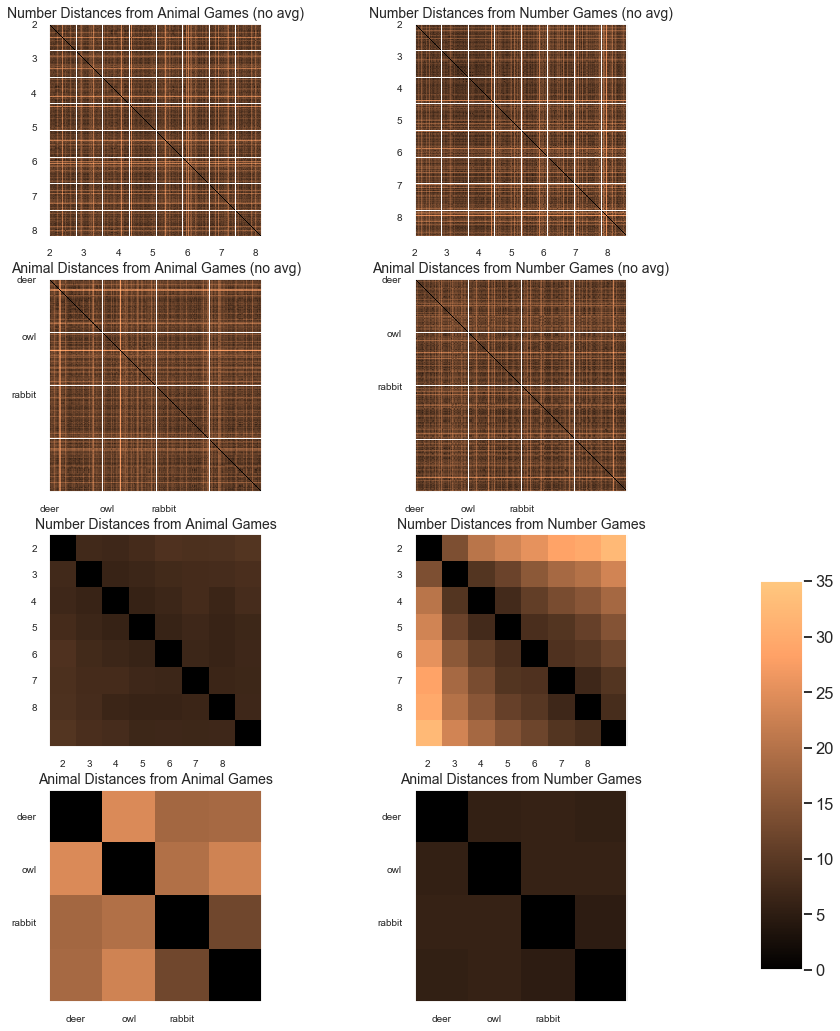

In [10]:
fig, ((axA,axB), (axC,axD), (ax1,ax2), (ax3,ax4)) = plt.subplots(4,2, figsize = (12,18))

axA.set_title("Number Distances from Animal Games (no avg)",fontsize=14)
plotA = axA.imshow(matA, cmap='copper', interpolation='nearest')#, vmin=0,vmax=35)
diag_nice_plot(axA,matA,['1','2','3','4','5','6','7','8'])

axB.set_title("Number Distances from Number Games (no avg)",fontsize=14)
plotB = axB.imshow(matB, cmap='copper', interpolation='nearest')#, vmin=0,vmax=35)
diag_nice_plot(axB,matB,['1','2','3','4','5','6','7','8'])


axC.set_title("Animal Distances from Animal Games (no avg)",fontsize=14)
plotC = axC.imshow(matC, cmap='copper', interpolation='nearest')#, vmin=0,vmax=35)
diag_nice_plot(axC,matC,['bear','deer','owl','rabbit'])

axD.set_title("Animal Distances from Number Games (no avg)",fontsize=14)
plotD = axD.imshow(matD, cmap='copper', interpolation='nearest')#, vmin=0,vmax=35)
diag_nice_plot(axD,matD,['bear','deer','owl','rabbit'])




ax1.set_title("Number Distances from Animal Games",fontsize=14)
plot1 = ax1.imshow(mat1, cmap='copper', interpolation='nearest', vmin=0,vmax=35)
diag_nice_plot(ax1,mat1,['1','2','3','4','5','6','7','8'],lines=False)

ax2.set_title("Number Distances from Number Games",fontsize=14)
plot2 = ax2.imshow(mat2, cmap='copper', interpolation='nearest', vmin=0,vmax=35)
diag_nice_plot(ax2,mat2,['1','2','3','4','5','6','7','8'],lines=False)


ax3.set_title("Animal Distances from Animal Games",fontsize=14)
plot3 = ax3.imshow(mat3, cmap='copper', interpolation='nearest', vmin=0,vmax=35)
diag_nice_plot(ax3,mat3,['bear','deer','owl','rabbit'],lines=False)

ax4.set_title("Animal Distances from Number Games",fontsize=14)
plot4 = ax4.imshow(mat4, cmap='copper', interpolation='nearest', vmin=0,vmax=35)
diag_nice_plot(ax4,mat4,['bear','deer','owl','rabbit'],lines=False)

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.3])
fig.colorbar(plot1, cax=cbar_ax)





In [ ]:
ax1.xaxis.tick_top()

ax1.set_xticklabels(ax.get_xticks()) #https://stackoverflow.com/questions/41122923/getting-empty-tick-labels-before-showing-a-plot-in-matplotlib
for tick in ax1.get_xticklabels()[:]:
    if float(tick.get_text()) > 1:
        tick.set_color("red")

In [ ]:
test = diag_struct(shape_games,'cardinality')
# test2 = test.reshape(232,232,4,4)[:,:,0,0]#.mean(axis=-2).shape

num = 8
pix = int(len(test)/num)

test3 = np.zeros((num,num))
for i in range(num):
    for j in range(num):
        test3[i,j] = test[i*pix:i*pix+pix,j*pix:j*pix+pix].mean()


plt.figure()
plt.imshow(test3, cmap='copper', interpolation='nearest',)
plt.show()

plt.figure()
plot_lines(plt,test,8)
plt.imshow(test, cmap='copper', interpolation='nearest')
plt.show()


In [ ]:
# # some simple plots
# plt.title("Animal Distances from Animal Games")
# plot_diag_struct(shape_games,'animal',grouping = 'animal')
# plt.colorbar()
# plt.figure()
# plt.title("Animal Distances from Number Games")
# plot_diag_struct(number_games,'animal',grouping = 'animal')
# plt.colorbar()
# plt.figure()
# plt.title("Cardinality Distances from Animal Games")
# plot_diag_struct(shape_games,'cardinality',grouping = 'cardinality')
# plt.colorbar()
# plt.figure()
# plt.title("Cardinality Distances from Number Games")
# plot_diag_struct(number_games,'cardinality',grouping = 'cardinality')
# plt.colorbar()

# Do some distance measurements
### plot by-game to see between-game (regardless of card/anim) distances

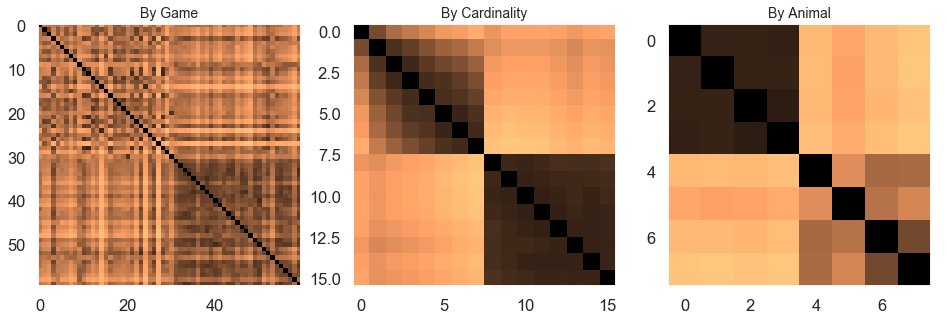

In [185]:

feat_cols = [str(i) for i in np.arange(4096)]


by_game_df1 = D.sort_values(['condition','game_id']).groupby(['condition','game_id']).mean()
by_game_df2 = D.sort_values(['condition','game_id']).groupby(['condition','cardinality']).mean()
by_game_df3 = D.sort_values(['condition','game_id']).groupby(['condition','animal']).mean()

by_game1 = np.array(by_game_df1[feat_cols])
by_game2 = np.array(by_game_df2[feat_cols])
by_game3 = np.array(by_game_df3[feat_cols])

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (16,6))
plt.title("Inter-Game Avg. Sketch Distances",fontsize=14)
ax1.set_title("By Game",fontsize=14)
ax2.set_title("By Cardinality",fontsize=14)
ax3.set_title("By Animal",fontsize=14)

ax1.imshow(squareform(pdist(by_game1)), cmap='copper', interpolation='nearest')
ax2.imshow(squareform(pdist(by_game2)), cmap='copper', interpolation='nearest')
ax3.imshow(squareform(pdist(by_game3)), cmap='copper', interpolation='nearest')

# plt.xticks([15,45], ['Number', 'Shape'],fontsize=14)
# plt.yticks([15,45], ['Number', 'Shape'],fontsize=14,rotation=90)
plt.show()


In [276]:
# shape_games.sort_values('cardinality')
# number_games.sort_values('cardinality')
# shape_games.sort_values('animal')
# number_games.sort_values('animal')

def f_test(df,category):
    feat_cols = [str(i) for i in np.arange(4096)]
    
    # making numerator of f test ratio (between group variance)
    total_mean = np.array(df.groupby('condition').mean()[feat_cols])
    group_means = np.array(df.groupby(category).mean()[feat_cols])
    dists = np.sqrt(np.sum(((group_means - total_mean) ** 2),axis=1))
    sum_sq_btwn = np.sum( dists**2  / (len(group_means) - 1), axis = 0)
    
    # making denominator (within group variance)
    group_variances = np.sqrt(np.sum(np.array(df.groupby(category).var()[feat_cols])**2, axis = 1))

    wthn_variance = np.sum(group_variances, axis = 0) / (len(df) - len(group_variances))
    
    return sum_sq_btwn / wthn_variance

# np.shape(np.array(shape_games.groupby('cardinality').mean()[feat_cols]) - np.array(shape_games.groupby('condition').mean()[feat_cols]))


len(np.sum(np.array(shape_games.groupby('cardinality').var()[feat_cols]),axis=1))

print(f_test(shape_games,'cardinality'))
print(f_test(number_games,'cardinality'))
print(f_test(shape_games,'animal'))
print(f_test(number_games,'animal'))



38.31888276329079
203.29647743093489
607.7913208528324
53.048021311631544


### get F-statistic for cardinality or animal as grouping principle (ratio of between- vs within- category variance)

Animal games sorted by animal 0.9040913936397225
Animal games sorted by number 0.8971629858246589 

Number games sorted by number 0.8566372843155982
Number games sorted by animal 0.9540825282043505 



Text(0.5,1,'Number games by animal')

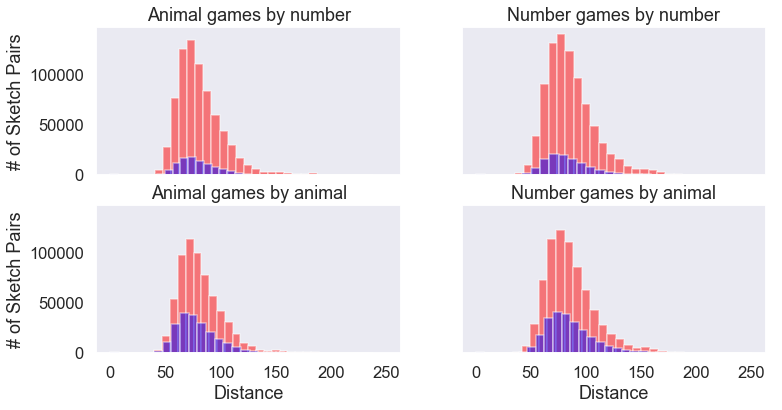

In [126]:

# Don't just plot the ratio of variances - plot all distances and see if within- and between- have overlapping normal curves
def wthn_btwn_var(matrix,labels):
    betwen_cat = np.where(make_mask(labels) == False,matrix,np.nan)
    within_cat = np.where(make_mask(labels) == True,matrix,np.nan)
    return np.nanvar(betwen_cat) / np.nanvar(within_cat)  # use var instead??? But these are already distances...

print("Animal games sorted by animal", wthn_btwn_var(matC,labelsC))
print("Animal games sorted by number", wthn_btwn_var(matA,labelsA),'\n')

print("Number games sorted by number", wthn_btwn_var(matB,labelsB))
print("Number games sorted by animal", wthn_btwn_var(matD,labelsD),'\n')

def wthn_btwn_dist(matrix,labels,subplot):
    betwen_cat = np.where(make_mask(labels) == False, matrix, np.nan)
    within_cat = np.where(make_mask(labels) == True, matrix, np.nan)
    
    betwen_cat = betwen_cat.flatten()
    ii = np.isfinite(betwen_cat)
    betwen_cat = np.sort(betwen_cat[ii])
    
    within_cat = within_cat.flatten()
    ii = np.isfinite(within_cat)
    within_cat = np.sort(within_cat[ii])
    
    
    subplot.hist(betwen_cat,bins=30,color='red',alpha=.5)
    subplot.hist(within_cat,bins=30,color='blue',alpha=.5)
    
    
#     return betwen_cat, within_cat

fig , ((hist1,hist2),(hist3,hist4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(12,6))
wthn_btwn_dist(matA,labelsA,hist1)
wthn_btwn_dist(matB,labelsB,hist2)
wthn_btwn_dist(matC,labelsC,hist3)
wthn_btwn_dist(matD,labelsD,hist4)

hist1.set_ylabel('# of Sketch Pairs')
hist3.set_ylabel('# of Sketch Pairs')

hist3.set_xlabel('Distance')
hist4.set_xlabel('Distance')

hist1.set_title("Animal games by number")
hist2.set_title("Number games by number")
hist3.set_title("Animal games by animal")
hist4.set_title("Number games by animal")

# plt.figure()
# plt.plot(range(len(btwn)),btwn,color='red')
# plt.plot(range(len(wthn)),wthn,color='blue')
# plt.show()






# Then do classifier-based things

In [200]:
Q = D
# Q = shuffle(D)

X = np.array(Q[feat_cols])
y_C = Q['cardinality'].values
y_A = Q['animal'].values


X_A = np.array(shape_games[feat_cols])
X_C = np.array(number_games[feat_cols])
y_CC = number_games['cardinality'].values
y_AA = shape_games['animal'].values


start_time = datetime.now() 

# making training and test sets from cardinalities
X_C_train, X_C_test, y_C_train, y_C_test = train_test_split(X_C, y_CC,
#                                                             stratify=y_C,
                                                            test_size=0.1,
                                                            shuffle=True)
end_time = datetime.now()
total_time = end_time - start_time
print('time: {}'.format(total_time))


start_time = datetime.now() 

# making training and test sets from animal information
X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(X_A, y_AA,
#                                                             stratify=y_A,
                                                            test_size=0.1,
                                                            shuffle=True)
end_time = datetime.now()
total_time = end_time - start_time
print('time: {}'.format(total_time))



time: 0:00:00.065070
time: 0:00:00.099047


In [147]:
np.sum(X_C_test == X_A_test) / np.size(X_C_test == X_A_test)


0

### within game type, train logistic classifier (5-fold) and measure (1) accuracy & (2) confusion (structure of error; e.g. is 5 often confused with 6? Are deer often confused with bear? Do each for each game type)

In [201]:
clf_C = linear_model.LogisticRegression(penalty='l2',
                                      C=1e-3,
                                      random_state=0,
                                      solver='lbfgs',
                                      multi_class='multinomial',
                                      max_iter=1500).fit(X_C_train, y_C_train) 

clf_A = linear_model.LogisticRegression(penalty='l2',
                                      C=1e-3,
                                      random_state=0,
                                      solver='lbfgs',
                                      multi_class='multinomial',
                                      max_iter=1500).fit(X_A_train, y_A_train) 


dump(clf_C, 'cardinality_clf.joblib') 
dump(clf_A, 'animal_clf.joblib') 

# print('Cardinality accuracy on cardinality test data: {}'.format(clf_C.score(X_C_test, y_C_test)))
# print('Animal accuracy on animal test data: {}'.format(clf_A.score(X_A_test, y_A_test)))
# print('Cardinality accuracy on animal test data: {}'.format(clf_C.score(X_A_test, y_A_test)))
# print('Animal accuracy on cardinality test data: {}'.format(clf_A.score(X_C_test, y_C_test)))



['animal_clf.joblib']

In [71]:
# print(dir(clf))

# coefs_C = clf_C.coef_
# coefs_A = clf_A.coef_

# coefs_C_sorted = coefs_C[:,coefs_C[-1].argsort()]
# coefs_A_sorted = coefs_A[:,coefs_A[-1].argsort()]

# for row in coefs_C_sorted:
#     plt.figure(figsize = (4,4)) #figsize = (16,8)
#     plt.plot(np.arange(len(row)),row,'.')


### ACCURACY:

In [149]:


reallyRun = 1
if reallyRun:
    start_time = datetime.now() 
    scores_AA = cross_validate(clf_A, X_A_test, y_A_test,
                               cv=5, return_train_score=True)
    scores_AC = cross_validate(clf_A, X_C_test, y_C_test,
                               cv=5, return_train_score=True)
    
    scores_CC = cross_validate(clf_C, X_C_test, y_C_test,
                               cv=5, return_train_score=True)
    scores_CA = cross_validate(clf_C, X_A_test, y_A_test,
                               cv=5, return_train_score=True)
    
    end_time = datetime.now()
    total_time = end_time - start_time
    print('Scores AA: {}'.format(scores_AA['test_score']))
    print('Scores AC: {}'.format(scores_AC['test_score']))
    print('Scores CC: {}'.format(scores_CC['test_score']))
    print('Scores CA: {}'.format(scores_CA['test_score']))
    print('total time: {}'.format(total_time))


Scores AA: [0.61904762 0.52380952 0.76470588 0.70588235 0.52941176]
Scores AC: [0.25       0.38095238 0.42105263 0.47368421 0.29411765]
Scores CC: [0.25       0.38095238 0.42105263 0.47368421 0.29411765]
Scores CA: [0.61904762 0.52380952 0.76470588 0.70588235 0.52941176]
total time: 0:00:03.963636


In [192]:
len(y_A_train) / len(y_pred)

0.4832175925925926

In [224]:


clf = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2',
                                      C=1e-3,
                                      random_state=0,
                                      solver='lbfgs',
                                      multi_class='multinomial',
                                      max_iter=1500))

y_A_pred = cross_val_predict(clf, X_A_train, y_A_train, cv=5)
y_C_pred = cross_val_predict(clf, X_C_train, y_C_train, cv=5)

conf_mat_A = confusion_matrix(y_A_train, y_A_pred)
conf_mat_C = confusion_matrix(y_C_train, y_C_pred)


### CONFUSION:

array([115, 112, 111, 109, 110, 106, 113, 116])

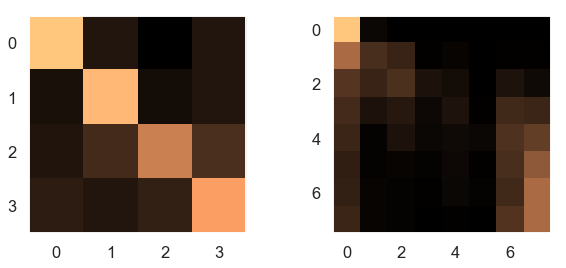

In [286]:
fig , (ax1,ax2) = plt.subplots(1,2 , figsize=(10,4))
ax1.imshow(conf_mat_A, cmap='copper', interpolation='nearest')
ax2.imshow(conf_mat_C, cmap='copper', interpolation='nearest')
np.sum(conf_mat_C,axis=1)


### track the (3) 'probability' from softmax output to have something continuous

In [218]:
# Xarray-like of shape (n_samples, n_features)
# Vector to be scored, where n_samples is the number of samples and n_features is the number of features.

# DON'T WORRY ABOUT LOG ODDS. JUST TAKE THE WINNING PROBABILITY

# softmax:
print(np.argmax(clf_A.predict_proba(X_A_test),axis=1),'\n')
# print(np.sum(clf_C.predict_proba(X_A_train),axis=0),'\n')
# print(np.sum(clf_A.predict_proba(X_C_train),axis=0),'\n')
# print(np.sum(clf_C.predict_proba(X_C_train),axis=0))

test = clf_A.predict_proba(X_A_test)
test[:] = 0
for i in range(len(test)):
    test[i,np.argmax(clf_A.predict_proba(X_A_test),axis=1)[i]] = 1
    
print(len(test), len(clf_A.predict_proba(X_A_test)))

# print(clf_C.classes_)


[3 1 2 3 3 1 3 1 1 2 2 2 3 2 3 2 0 3 2 2 3 2 3 2 2 3 2 0 0 0 1 3 2 0 0 2 3
 3 1 1 2 3 3 0 0 2 1 1 3 3 1 0 3 3 1 2 3 3 3 2 1 2 1 2 1 0 0 3 3 0 1 2 3 3
 1 2 2 2 1 1 1 0 2 1 0 0 0 1 0 1 0 2 2] 

93 93


In [219]:
# clf_A.predict_proba(X_A_test)
# clf_C.predict_proba(X_A_train)
# clf_A.predict_proba(X_C_train)
# clf_C.predict_proba(X_C_train)



In [120]:
# def i2animal(array):
#     """take an array of animal names and convert to scalars for reference"""

yC_new = np.zeros(len(y_C_train))
mapping = {'bear':0,'deer':1,'owl':2,'rabbit':3}

for index in range(len(y_A_train)):
    yC_new[index] = mapping[y_A_train[index]]
print(yC_new)

[2. 1. 2. ... 2. 2. 2.]


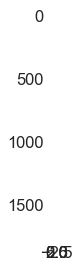

In [125]:
# print(np.sum(np.argmax(clf_A.predict_proba(X_A_train),axis=1) - yC_new),'\n')
plt.imshow(clf_A.predict_proba(X_A_train), cmap='copper', interpolation='nearest')


In [ ]:
yC_new = y_C_train.astype('float')
yC_new